In [1]:
import wave #for getting the wav file
import matplotlib.pyplot as plt #for plotting
import librosa #for doing all of the wavestuff
import numpy as np #vector stuff
import pandas as pd #dataframe
import torch #tesnor storage of the matrix data
import os 
import pandas as pd
from scipy.io import wavfile

# Load Data
load the wav file

In [2]:
file_path = 'testfileit.wav'

#with wave.open(file_path, 'rb') as wav_file: #read only
    # Read audio frames and get parameters.
#    audio_data = wav_file.readframes(wav_file.getnframes())
#    params = wav_file.getparams()
#print(params)
#print(type(audio_data), len(audio_data))

In [3]:
#do it in librosa
audio_data, sample_rate = librosa.load(file_path, sr=None)
pts = len(audio_data)
secs = pts/sample_rate #time of the clip
print(sample_rate, pts, secs)

48000 215040 4.48


# Look at the fourier transform

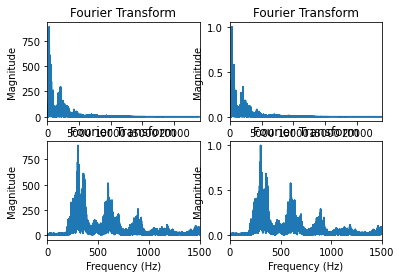

In [4]:
#Get the Fourier transform
fourier = np.fft.fft(audio_data)

#Get the spectrum
magspectrum = np.abs(fourier)

#Normalize the magnitude spectrum
nmagspectrum = magspectrum/np.max(magspectrum)

# Plot the fourier spectrum and the normalized one (should look same)
plt.subplot(2, 2, 1)  # (rows, columns, index)
frequencies = abs(np.fft.fftfreq(len(fourier), d=1/sample_rate)) #get the frequencies that correspond to the fourier magnitudes
plt.plot(frequencies, magspectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.xlim(0, sample_rate / 2)
#plt.show()

plt.subplot(2, 2, 2)  # (rows, columns, index)
plt.plot(frequencies, nmagspectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.xlim(0, sample_rate / 2)
#plt.show()

plt.subplot(2, 2, 3)  # (rows, columns, index)
frequencies = abs(np.fft.fftfreq(len(fourier), d=1/sample_rate)) #get the frequencies that correspond to the fourier magnitudes
plt.plot(frequencies, magspectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.xlim(0, 1500)
#plt.show()

plt.subplot(2, 2, 4)  # (rows, columns, index)
plt.plot(frequencies, nmagspectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform')
plt.xlim(0, 1500)
plt.show()

In [5]:
#set up a function to get the fourier transform information for any set of clips
def get_fourier(clip):
    #Get the Fourier transform
    fourierf = np.fft.fft(clip)
    #Get the spectrum
    magspectrumf = np.abs(fourierf)
    frequenciesf = abs(np.fft.fftfreq(len(fourierf), d=1/sample_rate)) #get the frequencies that correspond to the fourier magnitudes

    #get the f with max magnitude
    magmaxf = np.max(magspectrumf) 
    #find the index
    fmaxindexf = np.where(magspectrumf == magmaxf)
    #get the corresponding frequencyw
    maxpff = frequenciesf[int(np.max(fmaxindexf[0]))] #frequency of maximum power at any point during the clip. If there are 2 points, pick one.

    #define max f as highest f with 1/3 of the peak frequency
    isrelmaxf = torch.tensor(magspectrumf > magmaxf/3).to(torch.float)
    relfsf = torch.tensor(frequenciesf)*isrelmaxf #frequencies over 1/3 max mult by 1, others zeroed out
    maxff = max(relfsf).numpy() #maximum frequency
    #define min f as lowest f with 1/3 of the peak (may often be 0)
    minff = min(relfsf).numpy()
    #the BW of the magnitudes is max-min
    bwfourierf = maxff-minff
    fourieroutf = (magmaxf, maxpff, maxff.item(), minff.item(), bwfourierf)
    return fourieroutf

In [6]:
overallfourier = get_fourier(audio_data) #all of the info from the fourier transform for the whole file
#0) max magnitude of fourier, 1) f for max magnitude, 2) highest relevant f, 3) lowest relevant f, 4) max-min relevant f
print(overallfourier)
maxf = overallfourier[2]

(888.5912456260182, 302.45535714285717, 637.5, 0.0, 637.5)


# Other Spectral Features

In [7]:
#setup:
n_fft = round(512*sample_rate/22050) #512 recommended for voice at 22050 Hz
hoplwhole = sample_rate*3 #when we want data for the whole thing
hopl = round(sample_rate/5) #number of audio samples between adjacent STFT columns, we want 200ms chunks
#frequency resolution
f_res = sample_rate/n_fft
print(n_fft, hopl, f_res)

1115 9600 43.04932735426009


In [8]:
def get_spec(clip, hoplen):
    #Get BW
    bw = librosa.feature.spectral_bandwidth(y=clip, sr=sample_rate, hop_length=hoplen)[0] #sometimes gives 2 items in vector, one can be 0
    #Get the spectral rolloff
    specroll = librosa.feature.spectral_rolloff(y= clip, sr=sample_rate, n_fft=n_fft, hop_length=hoplen, roll_percent=0.85)[0]#sometimes gives 2 items in vector, one can be 0
    #get fundamental frequency
    try:
        f0 = np.nanmean(librosa.pyin(y=clip, fmin = 60, fmax = maxf, sr=sample_rate)[0])
    except RuntimeWarning:
        f0 = 0
    spect = [bw[0], specroll[0], f0]
    return spect

In [9]:
spectdata = get_spec(audio_data, hoplwhole) #0) spectral bandwith, 1) spectrall rolloff f, 2) fundamental freq f0
print(spectdata)

[0.0, 0.0, 285.45158413374617]


In [10]:
#get range/f0
rangef0 = overallfourier[4]/spectdata[2]
print(rangef0)

2.2333034231868343


Get the data for segment clips

In [11]:
n = 6 #number of sections to split into +1
#the shortest filess are 1 second and we don't want clips shorter than 200 ms since that's what the human ear picks up
pps = np.round(pts/n) #points per section, with the last section getting the extras or shorted
cutoffs = [int(pps * i) for i in range(0, n-1)]
cutoffs.append(int(pts))

freqdata = []
for i in range(0, n-1):
    shortclip = audio_data[cutoffs[i]:cutoffs[i+1]]
    bws = max(librosa.feature.spectral_bandwidth(y=shortclip, sr=sample_rate, hop_length=hopl*3)[0])
    fc = get_fourier(shortclip)
    sc = get_spec(shortclip, hopl)
    rangef0c = fc[4]/sc[2]
    freqdata.append([fc[0], fc[1], fc[2], fc[3], sc[0], sc[1], sc[2], rangef0c])
#print(freqdata) 
#0) max magnitude of fourier, 1) f for max magnitude, 2) highest relevant f, 
#3) lowest relevant f, 4) max-min relevant f, 5) spectral bandwith, 
#6) spectrall rolloff f, 7) fundamental freq f0, 8) range/f0

# Look at the spectrogram

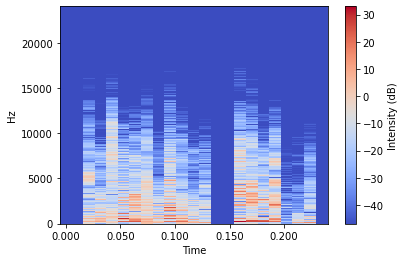

In [12]:
#get the short-term fourier transform
fourierplt = librosa.stft(audio_data, n_fft=n_fft, hop_length=hopl)
#convert it from raw values to dB (log)
findbplt = librosa.amplitude_to_db(abs(fourierplt))
#look at the spectrogram
librosa.display.specshow(findbplt, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar(label='Intensity (dB)')
plt.show()

In [13]:
#get the frequencies with the max power
def get_fpwr(clip):
    
    fourier = librosa.stft(clip, n_fft=n_fft, hop_length=hopl)
    #convert it from raw values to dB (log)
    findb = librosa.amplitude_to_db(abs(fourier))
    #0 is the frequency bins, 1 is the time stamp
    #frequency corresponding to each row
    f_bins = [i * f_res for i in range(fourier.shape[0])]
    
    #get the max energy value
    overallmaxdb = np.max(findb) 
    #find the row it's in
    overallindex = np.where(findb == overallmaxdb)
    #get the corresponding frequency for that row
    maxptf=f_bins[int(overallindex[0])] #frequency of maximum power at any point during the clip

    #sum up the energy for all time periods for each row
    rowsums = np.sum(fourier, axis=1)
    #get the max energy value
    rowmax = np.max(rowsums)
    #find the row it's in
    sumindex = np.where(rowsums == rowmax)
    #get the corresponding frequency for that row
    maxsumf=f_bins[int(sumindex[0])] #frequency of maximum power throughout the clip
    return(maxptf, maxsumf)

In [14]:
maxpwr = get_fpwr(audio_data)
print(maxpwr)

(301.3452914798207, 258.29596412556054)


In [15]:
#get the spectral centroid
def get_spc(clip):
    centroidvect = librosa.feature.spectral_centroid(y=clip, sr=sample_rate)
    meancent = np.mean(centroidvect)
    return meancent

For the whole file:

In [16]:
filemeancent = get_spc(audio_data)
print(filemeancent)

2211.8906487556


Split the waveplot into sections and get data for each

In [17]:
n = 6 #number of sections to split into +1
#the shortest filess are 1 second and we don't want clips shorter than 200 ms since that's what the human ear picks up
pps = np.round(pts/n) #points per section, with the last section getting the extras or shorted
cutoffs = [int(pps * i) for i in range(0, n-1)]
cutoffs.append(int(pts))

In [18]:
segsum = []
for i in range(0, n-1):
    shortclip = audio_data[cutoffs[i]:cutoffs[i+1]]
    maxdata = get_fpwr(shortclip)
    centdata= get_spc(shortclip)
    bws = librosa.feature.spectral_bandwidth(y=shortclip, sr=sample_rate, hop_length=hopl*3)[0]
    #print(bws[0])
    segsum.append([maxdata[0], maxdata[1], centdata]) #f of peak pt energy, f of max total energy, centroid f, bandwidth

In [19]:
#raw info for each of the segments
print(segsum)

[[258.29596412556054, 258.29596412556054, 1526.9278618428007], [301.3452914798207, 344.39461883408075, 3050.8648352905593], [645.7399103139014, 645.7399103139014, 2791.8567970729837], [258.29596412556054, 258.29596412556054, 1545.0721038374857], [344.39461883408075, 344.39461883408075, 2194.2444221160285]]


Add comparisons to "normalize" the amplitudes to baseline

In [20]:
#Use the overall file mean centroid as the normalizer.
nmaxpwr = maxpwr/filemeancent
nseg = torch.tensor(segsum/filemeancent)



In [21]:
powervect = (maxpwr[0], maxpwr[1], nmaxpwr[0], nmaxpwr[1]) #max f at any point, f w max power, normalized max f at any point, normalized f w max power
segmat = torch.cat((torch.tensor(segsum), nseg), dim=1) #rows are each segment, 
#columns are f of peak pt energy, f of max total energy, centroid f, normalized f peak pt energy, normalized f max tot, normalized centroid

print(powervect, segmat)

(301.3452914798207, 258.29596412556054, 0.13623878361679237, 0.11677610024296486) tensor([[2.5830e+02, 2.5830e+02, 1.5269e+03, 1.1678e-01, 1.1678e-01, 6.9033e-01],
        [3.0135e+02, 3.4439e+02, 3.0509e+03, 1.3624e-01, 1.5570e-01, 1.3793e+00],
        [6.4574e+02, 6.4574e+02, 2.7919e+03, 2.9194e-01, 2.9194e-01, 1.2622e+00],
        [2.5830e+02, 2.5830e+02, 1.5451e+03, 1.1678e-01, 1.1678e-01, 6.9853e-01],
        [3.4439e+02, 3.4439e+02, 2.1942e+03, 1.5570e-01, 1.5570e-01, 9.9202e-01]],
       dtype=torch.float64)


# Find the gradient/differences

Combine all segment data

In [22]:
freqmat = torch.cat((torch.tensor(freqdata), torch.tensor(freqdata)/filemeancent),dim=1)#includes raw and normalized fourier and spectral data
allsegdata = torch.cat((segmat, freqmat), dim=1)
print(allsegdata.shape)

torch.Size([5, 22])


In [23]:
#to compare easily, make a new tensor that is the old one shifted. For sizing, need to make the original one line bigger as well
zerost = torch.zeros(1, 22)
lastt = torch.cat((allsegdata, zerost), dim=0)
nextt = torch.cat((zerost, allsegdata), dim=0)
diffs = nextt-lastt
grads = nextt/lastt #need to replace nans with 0s
print(diffs.shape, grads.shape)


torch.Size([6, 22]) torch.Size([6, 22])


In [24]:
#remove the last line since it doesn't have meaning and attach to the original summary to have something to return
tensoroutput = torch.cat((allsegdata, diffs[0:n-1], grads[0:n-1]), dim=1)
#columns: 0-2 segment f of peak pt energy, f of max total energy, centroid f 
#3-5: normalized 1-3.
#6-9: fourier outputs
#10-12: spectral outputs
#13: range/f0
#14-21: normalized 6-13
#22-34: raw difference between steps of first 14 
#35-66: % difference between steps of first 14.
shift = 22
print(tensoroutput.shape)

torch.Size([5, 66])


Let's plot some stuff to make sure that it makes sense

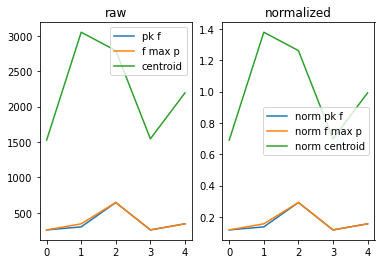

In [25]:
#stats and normalized stats
fpk = tensoroutput[:, 0]
fmax = tensoroutput[:, 1]
centf = tensoroutput[:, 2]
nfpk = tensoroutput[:, 3]
nfmax = tensoroutput[:, 4]
ncentf = tensoroutput[:, 5]

plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(fpk, label='pk f')
plt.plot(fmax, label='f max p')
plt.plot(centf, label='centroid')
plt.title('raw')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nfpk, label='norm pk f')
plt.plot(nfmax, label='norm f max p')
plt.plot(ncentf, label='norm centroid')
plt.title('normalized')
plt.legend()

plt.show()

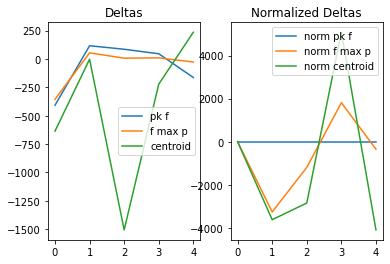

In [26]:
#changes and normalized changes
deltafpk = tensoroutput[:, 6+ shift]
deltafmax = tensoroutput[:, 7+ shift]
deltacentf = tensoroutput[:, 8+ shift]
deltanfpk = tensoroutput[:, 9+ shift]
deltanfmax = tensoroutput[:, 10+ shift]
deltancentf = tensoroutput[:, 11+ shift]


plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(deltafpk, label='pk f')
plt.plot(deltafmax, label='f max p')
plt.plot(deltacentf, label='centroid')
plt.title('Deltas')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deltanfpk, label='norm pk f')
plt.plot(deltanfmax, label='norm f max p')
plt.plot(deltancentf, label='norm centroid')
plt.title('Normalized Deltas')
plt.legend()

plt.show()


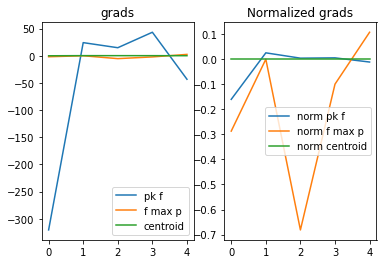

In [27]:
#changes and normalized changes
gradfpk = tensoroutput[:, 12+ shift]
gradfmax = tensoroutput[:, 13+ shift]
gradcentf = tensoroutput[:, 14+ shift]
gradnfpk = tensoroutput[:, 15+ shift]
gradnfmax = tensoroutput[:, 16+ shift]
gradncentf = tensoroutput[:, 17+ shift]


plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(gradfpk, label='pk f')
plt.plot(gradfmax, label='f max p')
plt.plot(gradcentf, label='centroid')
plt.title('grads')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gradnfpk, label='norm pk f')
plt.plot(gradnfmax, label='norm f max p')
plt.plot(gradncentf, label='norm centroid')
plt.title('Normalized grads')
plt.legend()

plt.show()


# Chroma/Tonnez

In [28]:
chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate, hop_length=hoplwhole, n_fft=n_fft)
print(chroma)

[[0.         0.26881847]
 [0.         0.46086994]
 [0.         0.77384454]
 [0.         1.        ]
 [0.         0.75983137]
 [0.         0.50251526]
 [0.         0.27757475]
 [0.         0.09241647]
 [0.         0.1264679 ]
 [0.         0.11521322]
 [0.         0.11209217]
 [0.         0.13814206]]


In [29]:
tonnez = librosa.feature.tonnetz(y=audio_data, sr=sample_rate)
print(tonnez)

[[ 1.18804140e-04  2.06514319e-03  2.15594872e-03 ... -1.35305766e-02
  -1.10747628e-02 -9.11307462e-03]
 [ 4.12342596e-02  3.14548470e-02  3.64640069e-02 ...  1.23268881e-02
   1.36795239e-02  1.14276461e-02]
 [-2.12848701e-01 -2.10384028e-01 -2.04748411e-01 ...  3.33311958e-02
   4.01941491e-02  4.78159264e-02]
 [ 1.74358860e-02  9.50131193e-03  1.18085295e-02 ... -4.95270127e-02
  -5.35511989e-02 -5.88315912e-02]
 [ 4.10679431e-03  3.11027317e-03  2.85270900e-03 ...  8.64956626e-03
   5.35101996e-03  1.53672750e-03]
 [ 1.50600960e-02  1.23085179e-02  1.57280248e-02 ...  5.72090428e-02
   5.78991079e-02  5.83325159e-02]]


To compare with others, return the overall data as well as the tensor of segments

In [30]:
energypitch = (overallfourier, spectdata, maxpwr, filemeancent, tensoroutput, chroma)
